You can edit this notebook after copying to your drive.  
Click "Playgroundで開く" above and try them!  
  
(C) 2019 Tokyo Institute of Technology All Rights Reserved.  
@author Tatsuya Hiraoka  

In [0]:
# requirement
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cv

# Accelerated Proximal Gradient Method
- p13~

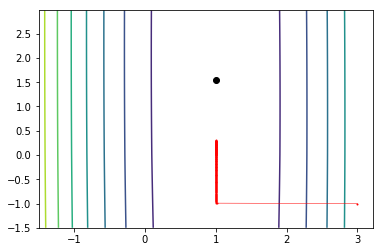

In [0]:
A = np.array([[300, 0.5],
              [0.5,   1]])
mu = np.array([[1],
               [2]])
lam = 0.89

x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# proximal gradient
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue)

x_init = np.array([[ 3],
                   [-1]])
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])

x_history = []
fvalues = []
xt = x_init
for t in range(170):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)
  
plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=1, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')


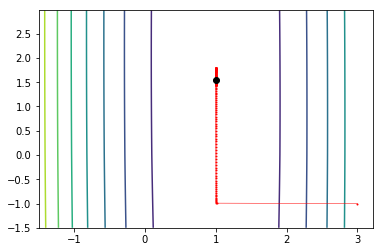

In [0]:
x_init = np.array([[ 3],
                   [-1]])

L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
xt = x_init

x_historyApg = [x_init.T]
s_history = [1]
v_history = [x_init.T]

fvaluesApg = []

for t in range(170):
  vt = v_history[-1].T
  grad = 2 * np.dot(A, vt - mu)
  xth = vt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  x_historyApg.append(xt.T)
  
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvaluesApg.append(fv)
  
  sprev = s_history[-1]
  st = (1 + np.sqrt(1 + 4 * sprev**2)) / 2.0
  s_history.append(st)
  qt = (sprev - 1.0) / st
  vnew = xt + np.dot(qt, (xt - x_historyApg[-2].T))
  v_history.append(vnew.T)
x_historyApg = np.vstack(x_historyApg)
fvaluesApg = np.vstack(fvaluesApg)
s_history = np.vstack(s_history)
v_history = np.vstack(v_history)
    
plt.contour(X1, X2, fValue)
plt.plot(x_historyApg[:,0], x_historyApg[:,1], 'ro-', markersize=1, linewidth=0.5);
plt.plot(w_lasso[0], w_lasso[1], 'ko')


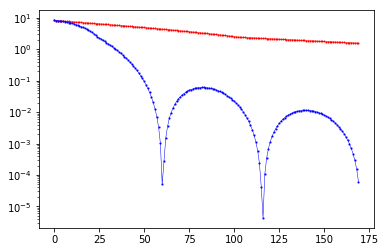

In [0]:
minfvalue = np.dot(np.dot((w_lasso-mu).T, A), w_lasso-mu) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesApg)])

plt.semilogy(fvalues - minOfMin, 'ro-', markersize=1, linewidth=0.5)
plt.semilogy(fvaluesApg - minOfMin, 'bs-', markersize=1, linewidth=0.5)

# Stochastic gradient decent (SGD)
- example on SVM
- This argolithm is based on Pegasos
- https://ttic.uchicago.edu/~nati/Publications/PegasosMPB.pdf

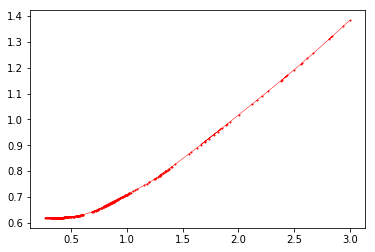

In [0]:
np.random.seed(17)

n = 40;
omega = np.random.randn()
noise = 0.8 * np.random.randn(n)
lam = 0.01
x = np.random.randn(n, 2)
y = 2 * (omega * x[:, 0] + x[:, 1] + noise > 0) - 1;

num_iter = 300
ww = 3
ll_historyBatch = []
ww_historyBatch = []
lip = 7 * np.max(x[:,0]**2)

for t in range(num_iter):
    ll = np.sum(np.maximum(0, 1 - y * (ww * x[:, 0] + x[:, 1])))/n + lam * (ww**2 + 1)
    ll_historyBatch.append(ll)
    ww_historyBatch.append(ww)
    idx = np.where(y*(ww*x[:,0]+x[:,1]) < 1.0)[0]
    
    diff_w = np.sum(-y[idx] * x[idx,0])
    ww = ww - 1/lip * diff_w - 2 * lam * ww

ll_historyBatch = np.vstack(ll_historyBatch)
ww_historyBatch = np.vstack(ww_historyBatch)

ww = 3
ll_history = []
ww_history = []
zt_history = []
lip = 1 * np.max(x[:,0]**2)

w1hat = np.arange(-3, 3, 0.01)

for t in range(num_iter):
    ll = np.sum(np.maximum(0, 1 - y * (ww * x[:,0] + x[:,1])))/n + lam * (ww**2 + 1)

    ll_history.append(ll)
    ww_history.append(ww)
    
    zt = np.random.randint(n)
    zt_history.append(zt)
    
    ywx_zt = y[zt] * (ww * x[zt, 0] + x[zt, 1])
    
    if ywx_zt < 1:
        diff_w = - y[zt] * x[zt,1]
    else:
        diff_w = 0
    ww = ww - 1/lip * diff_w - 2 * lam * ww;

ll_history = np.vstack(ll_history)
ww_history = np.vstack(ww_history)
zt_history = np.vstack(zt_history)

plt.plot(ww_history, ll_history, 'ro-', markersize=1, linewidth=0.5)


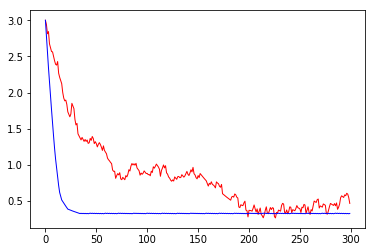

In [0]:
plt.plot(ww_history, 'r-', linewidth=1)
plt.plot(ww_historyBatch, 'b-', linewidth=1)

# GD in action with toy example
- p42
- compare the results by different `L`

(-1.5, 3)

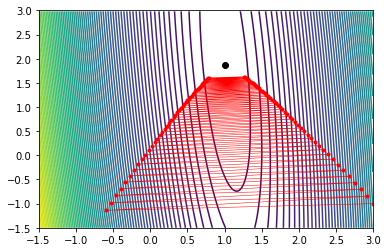

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])

L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
L /= 2

x_history = []
xt = x_init
for t in range(100):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  
x_history = np.vstack(x_history)
  
plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

# AdaGrad

(-1.5, 3)

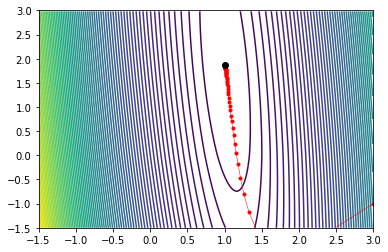

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])
xt = x_init
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
eta0 = 500/L;

x_history = []
fvalues = []
g_history = []
delta = 0.02;
# ht = 0.0
for t in range(100):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  
  g_history.append(grad.flatten().tolist())
#   ht += grad * grad
  ht = np.sqrt(np.sum(np.array(g_history)**2, axis=0).T) + delta
  ht = ht.reshape(2,1)
  
  eta_t = eta0
#   xth = xt - eta_t * (np.sqrt(ht)**-1 * grad)
  xth = xt - eta_t * (ht**-1 * grad)
#   ht_inv = np.sqrt(ht)**-1
  ht_inv = ht**-1
  xt = np.array([st_ops(xth[0], lam  * eta_t * ht_inv[0]),
                 st_ops(xth[1], lam  * eta_t * ht_inv[1])])
  
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)

plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)



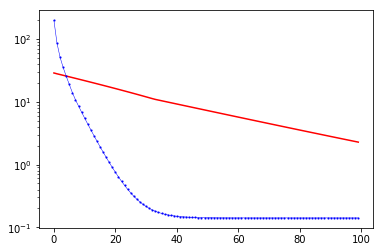

In [0]:
x_init = np.array([[ 3],
                   [-1]])
xt = x_init
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])

x_historyPg = []
fvaluesPg = []
xt = x_init
for t in range(100):
  x_historyPg.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvaluesPg.append(fv)

x_history = np.vstack(x_history)
fvaluesPg = np.vstack(fvaluesPg)

minfvalue = np.dot(np.dot((w_lasso - mu).T, A), (w_lasso - mu)) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesApg)])


plt.semilogy(fvaluesPg - minOfMin, 'r-')
plt.semilogy(fvalues - minOfMin, 'bs-', markersize=1, linewidth=0.5)

# Adam

(-1.5, 3)

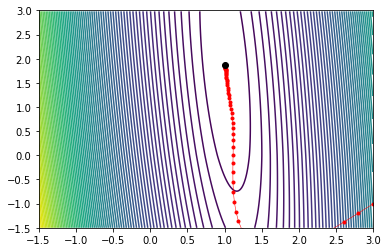

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])
xt = x_init

b1 = 0.7
b2 = 0.99999
ee = 1.0e-8
aa= 0.2

x_history = []
fvalues = []
g_history = []
mm = np.zeros((2,1))
vv = np.zeros((2,1))

for t in range(1,101):    
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  
  mm = b1 * mm + (1-b1) * grad
  vv = b2 * vv + (1 - b2) * (grad * grad)

  mmHat = mm / (1-b1**t)
  vvHat = vv / (1-b2**t)
    
  g_history.append(grad.T)

  rateProx = aa * np.ones((2, 1)) / (np.sqrt(vvHat) + ee)

  xth = xt -  mmHat * rateProx

  xt = np.array([st_ops(xth[0], lam  * rateProx[0]),
                 st_ops(xth[1], lam  * rateProx[1])])

  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)

plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

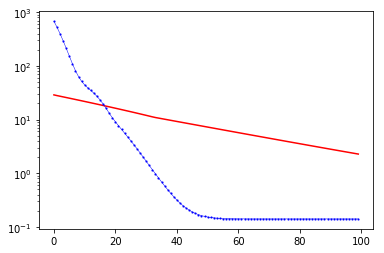

In [0]:
minfvalue = np.dot(np.dot((w_lasso - mu).T, A), (w_lasso - mu)) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesApg)])

plt.semilogy(fvaluesPg - minOfMin, 'r-')
plt.semilogy(fvalues - minOfMin, 'bs-', markersize=1, linewidth=0.5)

# RMSProp

In [0]:
# proximal gradient
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

(-1.5, 3)

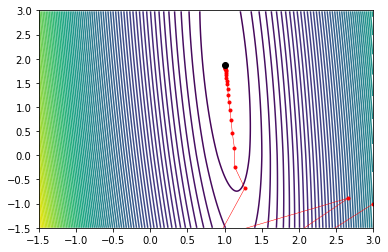

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])
xt = x_init
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
eta0 = 500/L;

b1 = 0.98
b2 = 0.99999
ee = 1.0e-8
aa= 0.2

x_history = []
fvalues = []
g_history = []
mm = np.zeros((2,1))
vv = np.zeros((2,1))

ht = np.zeros((2,1))
for t in range(100):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  
  g_history.append(grad.flatten().tolist())
  ht = b1 * ht + (1 - b1) * grad * grad
#   ht += grad * grad
  
  eta_t = eta0
  xth = xt - eta_t * (np.sqrt(ht+ee)**-1 * grad)
  ht_inv = np.sqrt(ht+ee)**-1
  xt = np.array([st_ops(xth[0], lam * eta_t * ht_inv[0]),
                 st_ops(xth[1], lam * eta_t * ht_inv[1])])
  
#   fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * np.sum(np.abs(xt))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)

plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

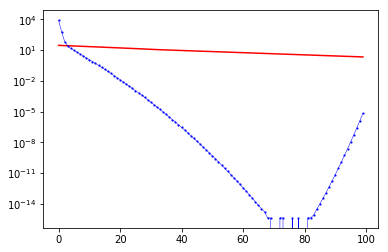

In [0]:
x_historyPg = []
fvaluesPg = []
xt = x_init
for t in range(100):
  x_historyPg.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvaluesPg.append(fv)

x_history = np.vstack(x_history)
fvaluesPg = np.vstack(fvaluesPg)

minfvalue = np.dot(np.dot((w_lasso - mu).T, A), (w_lasso - mu)) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesPg)])


plt.semilogy(fvaluesPg - minOfMin, 'r-')
plt.semilogy(fvalues - minOfMin, 'bs-', markersize=1, linewidth=0.5)

# Ada Delta

In [0]:
# proximal gradient
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

(-1.5, 3)

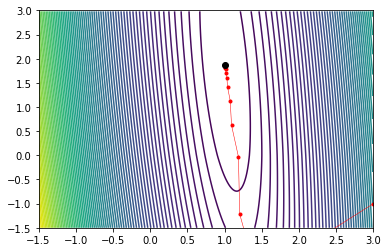

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])
xt = x_init
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
eta0 = 500/L;

b1 = 0.6
b2 = 0.99999
ee = 1.0e-6
aa= 0.2

x_history = []
fvalues = []
g_history = []
mm = np.zeros((2,1))
vv = np.zeros((2,1))

ht = np.zeros((2,1))
st = np.full((2,1), eta0 * eta0)
for t in range(100):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  
  g_history.append(grad.flatten().tolist())
  ht = b1 * ht + (1 - b1) * grad * grad
  vt = (np.sqrt(st) + ee) * ((np.sqrt(ht) + ee)**-1)
  
  xth = xt - vt * grad
  xt = np.array([st_ops(xth[0], lam * vt[0]),
                 st_ops(xth[1], lam * vt[1])])
  st = b1 * st + (1 - b1) * ((vt * grad) * (vt * grad))
  
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)

plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

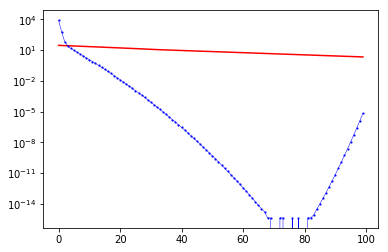

In [15]:
x_historyPg = []
fvaluesPg = []
xt = x_init
for t in range(100):
  x_historyPg.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvaluesPg.append(fv)

x_history = np.vstack(x_history)
fvaluesPg = np.vstack(fvaluesPg)

minfvalue = np.dot(np.dot((w_lasso - mu).T, A), (w_lasso - mu)) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesPg)])


plt.semilogy(fvaluesPg - minOfMin, 'r-')
plt.semilogy(fvalues - minOfMin, 'bs-', markersize=1, linewidth=0.5)

# Nadam

In [0]:
# proximal gradient
def st_ops(mu, q):
  x_proj = np.zeros(mu.shape)
  for i in range(len(mu)):
    if mu[i] > q:
      x_proj[i] = mu[i] - q
    else:
      if np.abs(mu[i]) < q:
        x_proj[i] = 0
      else:
        x_proj[i] = mu[i] + q; 
  return x_proj

(-1.5, 3)

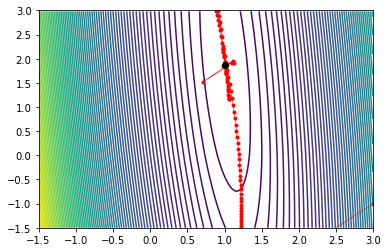

In [0]:
x_1 = np.arange(-1.5, 3, 0.01)
x_2 = np.arange(-1.5, 3, 0.02)

X1, X2 = np.mgrid[-1.5:3:0.01, -1.5:3:0.02]
fValue = np.zeros((len(x_1), len(x_2)))

A = np.array([[250, 15],
              [ 15,  4]])
mu = np.array([[1],
               [2]])
lam = 0.89

for i in range(len(x_1)):
  for j in range(len(x_2)):
    inr = np.vstack([x_1[i], x_2[j]])
    fValue[i, j] = np.dot(np.dot((inr-mu).T, A), (inr- mu)) + lam * (np.abs(x_1[i]) + np.abs(x_2[j]))

# cvx
w_lasso = cv.Variable((2,1))
obj_fn = cv.quad_form(w_lasso - mu, A) +  lam * cv.norm(w_lasso, 1)
objective = cv.Minimize(obj_fn)
constraints = []
prob = cv.Problem(objective, constraints)
result = prob.solve(solver=cv.CVXOPT) 
w_lasso = w_lasso.value

plt.contour(X1, X2, fValue, 80)

x_init = np.array([[ 3],
                   [-1]])
xt = x_init
L = 1.01 * np.max(np.linalg.eig(2 * A)[0])
eta0 = 500/L;

b1 = 0.93
b2 = 0.93
ee = 1.0e-8
aa= 0.2

x_history = []
fvalues = []
g_history = []
mm = np.zeros((2,1))
vv = np.zeros((2,1))

ht = np.zeros((2,1))
mt = np.zeros((2,1))
for t in range(1, 201):
  x_history.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  
  g_history.append(grad.flatten().tolist())
  mt = b2 * mt + (1 - b2) * grad
  ht = b1 * ht + (1 - b1) * grad * grad
  mht = b2 * mt / (1 - b2**(t + 1)) + (1 - b2) * grad / (1 - b2**t)
  ht = b1 * ht / (1 - b1**t)
  
  eta_t = eta0
  xth = xt - eta_t * (np.sqrt(ht+ee)**-1 * mht)
  ht_inv = np.sqrt(ht+ee)**-1
  xt = np.array([st_ops(xth[0], lam * eta_t * ht_inv[0]),
                 st_ops(xth[1], lam * eta_t * ht_inv[1])])
  
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvalues.append(fv)

x_history = np.vstack(x_history)
fvalues = np.vstack(fvalues)

plt.plot(x_history[:,0], x_history[:,1], 'ro-', markersize=3, linewidth=0.5)
plt.plot(w_lasso[0], w_lasso[1], 'ko')

plt.xlim(-1.5, 3)
plt.ylim(-1.5, 3)

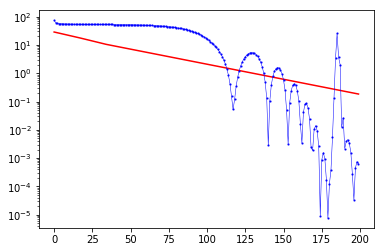

In [0]:
x_historyPg = []
fvaluesPg = []
xt = x_init
for t in range(200):
  x_historyPg.append(xt.T)
  grad = 2 * np.dot(A, xt-mu)
  xth = xt - 1/L * grad
  xt = st_ops(xth, lam * 1 / L)
  fv = np.dot(np.dot((xt - mu).T, A), (xt - mu)) + lam * (np.abs(xt[0]) + np.abs(xt[1]))
  fvaluesPg.append(fv)

x_history = np.vstack(x_history)
fvaluesPg = np.vstack(fvaluesPg)

minfvalue = np.dot(np.dot((w_lasso - mu).T, A), (w_lasso - mu)) + lam * np.sum(np.abs(w_lasso))
minOfMin = np.min([minfvalue,
                   np.min(fvalues),
                   np.min(fvaluesPg)])


plt.semilogy(fvaluesPg - minOfMin, 'r-')
plt.semilogy(fvalues - minOfMin, 'bs-', markersize=1, linewidth=0.5)